<a href="https://colab.research.google.com/github/jacquesbilombe/Payment-Patterns-Brazil/blob/main/Payment_Patterns_Brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Fetching and Saving

As mentioned at the project README.md, the proeject data is a public one, which can be find at [Kaggle](https://www.kaggle.com/datasets/clovisdalmolinvieira/brazilian-payment-methods).

![picture](https://drive.google.com/uc?export=view&id=12UFZ9lt2h-u_eYBqmkNoJuNtz2Z_m-xJ)

After finding the data needed for this project, it was downloaded locally before to be uploaded into a Google Clouud Storage Bucket. As the dataset, the bucket was setted without any restriction, meaning it's public; allowing anyone with the access to this Google Colab to run or download it without Google Authentification.

### GCP - Bucket

Following the steps from Google documentation or watching this official Google Tech video, anyone can create a bucket for their project:

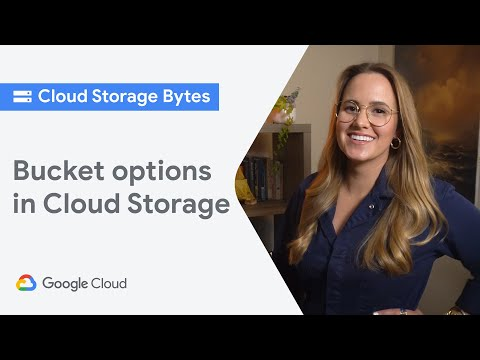

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('8DMOJ6Lgm7s', width=980, height=500)

The dataset was uploaded manually into the bucket:

![picture](https://drive.google.com/uc?export=view&id=16xDKxO5cwdbZSnaqXHCQPiDmArirAVwp)

## Modeling


### Schema


It was decided to apply a Star Schema using the uploaded data as raw. which result into two dataset, one whith the `Transaction information` and the other with `Date and Time`information.

Here is the SQL code to create the `Dim_Date_Time` and `Fact_Transaction` table:

```sql
CREATE TABLE Fact_Transactions (
    YearMonth CHAR(6) NOT NULL,
    quantityPix INT,
    valuePix DECIMAL(18,2),
    quantityTED INT,
    valueTED DECIMAL(18,2),
    quantityTEC INT,
    valueTEC DECIMAL(18,2),
    quantityBankCheck INT,
    valueBankCheck DECIMAL(18,2),
    quantityBrazilianBoletoPayment INT,
    valueBrazilianBoletoPayment DECIMAL(18,2),
    quantityDOC INT,
    valueDOC DECIMAL(18,2),
    CONSTRAINT fk_time FOREIGN KEY (YearMonth) REFERENCES Dim_Time(YearMonth)
);
```

```sql
CREATE TABLE Dim_Time (
    TimeKey INT PRIMARY KEY,
    YearMonth CHAR(6) NOT NULL,
    Year INT NOT NULL,
    Month INT NOT NULL
);
```

However, for this project, it was chosen `Pandas` instead of `SQL` for data transformation due to its flexibility and ease of use for in-memory data manipulation, which allows for rapid development and testing of data processing workflows.

In [11]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import storage

In [2]:
url = 'https://storage.googleapis.com/payment-patterns-brazil/brazilian_payment_methods.csv'
# Download the file (Public Access)
response = requests.get(url)

# Save the file locally
file_path = '/content/brazilian_payment_methods.csv'
with open(file_path, 'wb') as file:
    file.write(response.content)

# Read the CSV file
df = pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YearMonth                       101 non-null    int64  
 1   quantityPix                     101 non-null    float64
 2   valuePix                        101 non-null    float64
 3   quantityTED                     101 non-null    float64
 4   valueTED                        101 non-null    float64
 5   quantityTEC                     101 non-null    float64
 6   valueTEC                        101 non-null    float64
 7   quantityBankCheck               101 non-null    float64
 8   valueBankCheck                  101 non-null    float64
 9   quantityBrazilianBoletoPayment  101 non-null    float64
 10  valueBrazilianBoletoPayment     101 non-null    float64
 11  quantityDOC                     101 non-null    float64
 12  valueDOC                        101 

By looking  at the dataset, the colunms with "Quantity" of the transaction by payment method are identified as `Float` which doesn't make sense. In real world, there aren't 1.5 money transfer. As the result, all float of these columns will be rounded down (turn into integers).

In [3]:
def round_down(df):
  df['quantityPix'] = df['quantityPix'].astype('int32')
  df['quantityTED'] = df['quantityTED'].astype('int32')
  df['quantityTEC'] = df['quantityTEC'].astype('int32')
  df['quantityBankCheck'] = df['quantityBankCheck'].astype('int32')
  df['quantityBrazilianBoletoPayment'] = df['quantityBrazilianBoletoPayment'].astype('int32')
  df['quantityDOC'] = df['quantityDOC'].astype('int32')
  return df

df = round_down(df)
df.head()

,YearMonth,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
0,202405,5228826,2137205.79,69023,3482036.97,0,0.00,10467,40133.55,349180,506302.82,0,0.00
1,202404,4924681,2083746.68,70647,3652606.48,0,0.00,11179,43295.40,361633,524619.69,0,0.00
2,202403,4903392,1936188.21,67565,3333054.27,0,0.00,10122,36644.55,336435,469047.59,0,0.00
3,202402,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
4,202401,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YearMonth                       101 non-null    int64  
 1   quantityPix                     101 non-null    int32  
 2   valuePix                        101 non-null    float64
 3   quantityTED                     101 non-null    int32  
 4   valueTED                        101 non-null    float64
 5   quantityTEC                     101 non-null    int32  
 6   valueTEC                        101 non-null    float64
 7   quantityBankCheck               101 non-null    int32  
 8   valueBankCheck                  101 non-null    float64
 9   quantityBrazilianBoletoPayment  101 non-null    int32  
 10  valueBrazilianBoletoPayment     101 non-null    float64
 11  quantityDOC                     101 non-null    int32  
 12  valueDOC                        101 

In [4]:
# Create the time dimension table
df['Year'] = df['YearMonth'].astype(str).str[:4].astype(int)
df['Month'] = df['YearMonth'].astype(str).str[4:].astype(int)

dim_time = df[['YearMonth', 'Year', 'Month']].drop_duplicates().reset_index(drop=True)
dim_time['TimeKey'] = dim_time.index + 1

# Create the fact table
fact_transactions = df.copy()

In [ ]:
dim_time.head()

,YearMonth,Year,Month,TimeKey
0,202405,2024,5,1
1,202404,2024,4,2
2,202403,2024,3,3
3,202402,2024,2,4
4,202401,2024,1,5


In [5]:
# Merge with dim_time to get the TimeKey
fact_transactions = fact_transactions.merge(dim_time, on='YearMonth', how='left')

# Select relevant columns for fact table
fact_transactions = fact_transactions[['YearMonth','TimeKey', 'quantityPix', 'valuePix', 'quantityTED',
                                       'valueTED', 'quantityTEC', 'valueTEC', 'quantityBankCheck',
                                       'valueBankCheck', 'quantityBrazilianBoletoPayment',
                                       'valueBrazilianBoletoPayment', 'quantityDOC', 'valueDOC']]
fact_transactions.head()

,YearMonth,TimeKey,quantityPix,valuePix,quantityTED,valueTED,quantityTEC,valueTEC,quantityBankCheck,valueBankCheck,quantityBrazilianBoletoPayment,valueBrazilianBoletoPayment,quantityDOC,valueDOC
0,202405,1,5228826,2137205.79,69023,3482036.97,0,0.00,10467,40133.55,349180,506302.82,0,0.00
1,202404,2,4924681,2083746.68,70647,3652606.48,0,0.00,11179,43295.40,361633,524619.69,0,0.00
2,202403,3,4903392,1936188.21,67565,3333054.27,0,0.00,10122,36644.55,336435,469047.59,0,0.00
3,202402,4,4367133,1718217.65,65805,2981226.45,60,109.32,10373,37076.26,332269,463066.01,61,34.21
4,202401,5,4371541,1818473.97,70343,3337344.85,387,815.94,11919,41615.89,363550,516702.44,600,616.58


### Data Catalog

To archieve our goal in this part of the project, we'll follow these steps:
-  Minimum and Maximum Expected Values ​​for Numeric Data
- Description of Tables and Columns
- Categories for Categorical Data

In [ ]:
tb_payment = fact_transactions.copy()

def min_max(df):

  cols = df.columns
  min_max_df = pd.DataFrame(columns=["min", "max"])

  for col in cols:
      min_value = df[col].min()
      max_value = df[col].max()
      min_max_df.loc[col] = [min_value, max_value]

  return min_max_df

min_max_df = min_max(tb_payment)
min_max_df.reset_index(inplace=True)
min_max_df.rename(columns={"index": "column"}, inplace=True)

# min_max_df into dict
min_max_dict = min_max_df.set_index('column').to_dict()


In [ ]:
# Definir as columns do catálogo de dados
catalog_columns = ['Column', 'Description', 'Type', 'Min', 'Max', 'Categories']

# Criar uma lista de dicionários com as informações de cada column
catalog_data = [
    {'column': 'TimeKey', 'Description': 'Primary key, unique identifier of time', 'Type': 'Integer', 'Min': 1, 'Max': 'n', 'Categories': None},
    {'column': 'YearMonth', 'Description': 'Reference month and year in YYYYMM format', 'Type': 'Integer', 'Min': 201001, 'Max': 202312, 'Categories': None},
    {'column': 'quantityPix', 'Description': 'Number of PIX transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valuePix', 'Description': 'Total value of PIX transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityTED', 'Description': 'Number of TED transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueTED', 'Description': 'Total value of TED transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityTEC', 'Description': 'Number of TEC transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueTEC', 'Description': 'Total value of TEC transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityBankCheck', 'Description': 'Number of bank checks', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueBankCheck', 'Description': 'Total value of bank checks', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityBrazilianBoletoPayment', 'Description': 'Number of boleto payments', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueBrazilianBoletoPayment', 'Description': 'Total value of boleto payments', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'quantityDOC', 'Description': 'Number of DOC transactions', 'Type': 'Integer', 'Min': 0, 'Max': 'to be calculated', 'Categories': None},
    {'column': 'valueDOC', 'Description': 'Total value of DOC transactions', 'Type': 'Float', 'Min': 0.0, 'Max': 'to be calculated', 'Categories': None},
]


# Associate the dict min_max_dict with dict list catalog_data
for i in range(len(catalog_data)):
  column_name = catalog_data[i]['column']
  catalog_data[i]['Min'] = min_max_dict['min'][column_name]
  catalog_data[i]['Max'] = min_max_dict['max'][column_name]

# Criar um DataFrame a partir da lista de dicionários
catalog_df = pd.DataFrame(catalog_data)
catalog_df.head()

,column,Description,Type,Min,Max,Categories
0,TimeKey,"Primary key, unique identifier of time",Integer,1.0,101.00,None
1,YearMonth,Reference month and year in YYYYMM format,Integer,201601.0,202405.00,None
2,quantityPix,Number of PIX transactions,Integer,0.0,5228826.00,None
3,valuePix,Total value of PIX transactions,Float,0.0,2137205.79,None
4,quantityTED,Number of TED transactions,Integer,30728.0,193914.00,None


### Analysis

In this section, we'll try to answer all five questions made about this dataset previously:

- How has the adoption of different payment methods evolved?
- What are the most and least popular payment methods?
- How do the total values of transactions compare across different payment methods?
- Are there seasonal or monthly trends in using these payment methods?
- What insights can be derived from the transaction volumes and values about consumer behavior?

`Obs:` fact_transactions dataframe will be used as it has the entire dimension of the project.

#### 1. Evolution of payment methods adoption

In [15]:
df = fact_transactions.copy()
# Convert YearMonth to datetime
df['YearMonth'] = pd.to_datetime(df['YearMonth'], format='%Y%m')

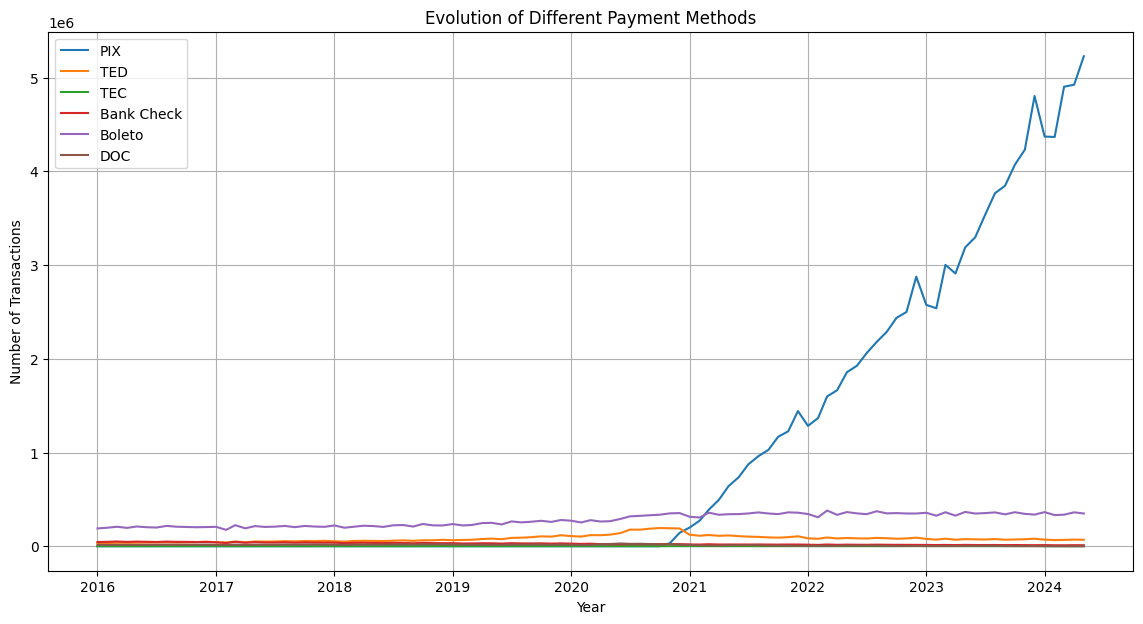

In [16]:
# Plot a linear chart telling the history of the payment method
plt.figure(figsize=(14, 7))
plt.plot(df['YearMonth'], df['quantityPix'], label='PIX')
plt.plot(df['YearMonth'], df['quantityTED'], label='TED')
plt.plot(df['YearMonth'], df['quantityTEC'], label='TEC')
plt.plot(df['YearMonth'], df['quantityBankCheck'], label='Bank Check')
plt.plot(df['YearMonth'], df['quantityBrazilianBoletoPayment'], label='Boleto')
plt.plot(df['YearMonth'], df['quantityDOC'], label='DOC')

plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.title('Evolution of Different Payment Methods')
plt.legend()
plt.grid(True)
plt.show()

Overtime, some payment methods remained constant such as Boleto, TEC, Bank Check; on the other hand the use of `Pix` as payment method gained popularity and becoming the prefer among people.

#### 2. Most and least popular payment methods

In [17]:
# Sum the quantity of transactions for each payment method
total_transactions = {
    'PIX': df['quantityPix'].sum(),
    'TED': df['quantityTED'].sum(),
    'TEC': df['quantityTEC'].sum(),
    'Bank Check': df['quantityBankCheck'].sum(),
    'Boleto': df['quantityBrazilianBoletoPayment'].sum(),
    'DOC': df['quantityDOC'].sum()
}

# Convert to DataFrame
total_transactions_df = pd.DataFrame(list(total_transactions.items()),
                                     columns=['Payment Method', 'Total Transactions'])


In [20]:
# Sort by total transactions
total_transactions_df = total_transactions_df.sort_values(by='Total Transactions',
                                                          ascending=False)

total_transactions_df.head()

,Payment Method,Total Transactions
0,PIX,99210145
4,Boleto,28421573
1,TED,8170212
3,Bank Check,2712097
5,DOC,1264689


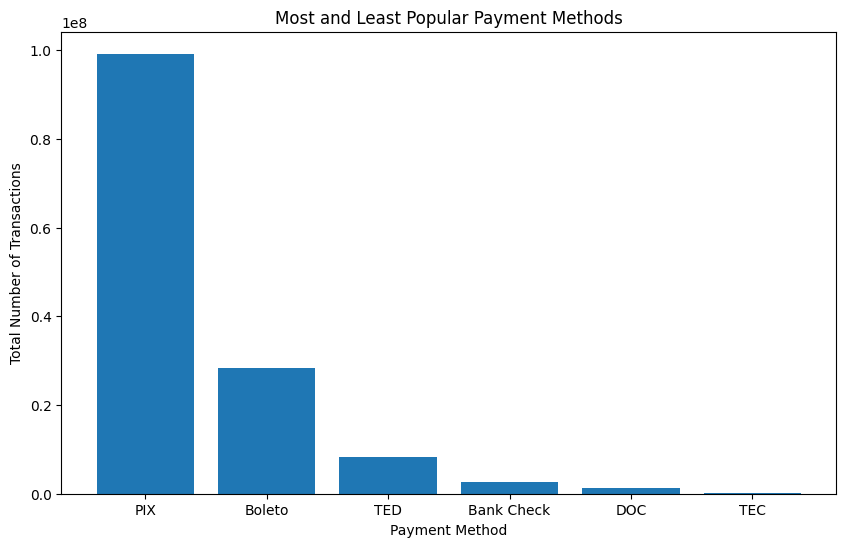

In [19]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(total_transactions_df['Payment Method'], total_transactions_df['Total Transactions'])
plt.xlabel('Payment Method')
plt.ylabel('Total Number of Transactions')
plt.title('Most and Least Popular Payment Methods')
plt.show()

#### 3. Comparison of total values of transactions across different payment methods

In [21]:
# Sum the value of transactions for each payment method
total_values = {
    'PIX': df['valuePix'].sum(),
    'TED': df['valueTED'].sum(),
    'TEC': df['valueTEC'].sum(),
    'Bank Check': df['valueBankCheck'].sum(),
    'Boleto': df['valueBrazilianBoletoPayment'].sum(),
    'DOC': df['valueDOC'].sum()
}

In [27]:
total_values_df = pd.DataFrame(list(total_values.items()),
                               columns=['Payment Method', 'Total Values (R$)'])

# Sort by total values
total_values_df = total_values_df.sort_values(by='Total Values (R$)',
                                              ascending=False)

total_values_df.head()

,Payment Method,Total Values (R$)
1,TED,2.365157e+08
0,PIX,4.311821e+07
4,Boleto,3.475548e+07
3,Bank Check,6.107002e+06
5,DOC,9.635028e+05


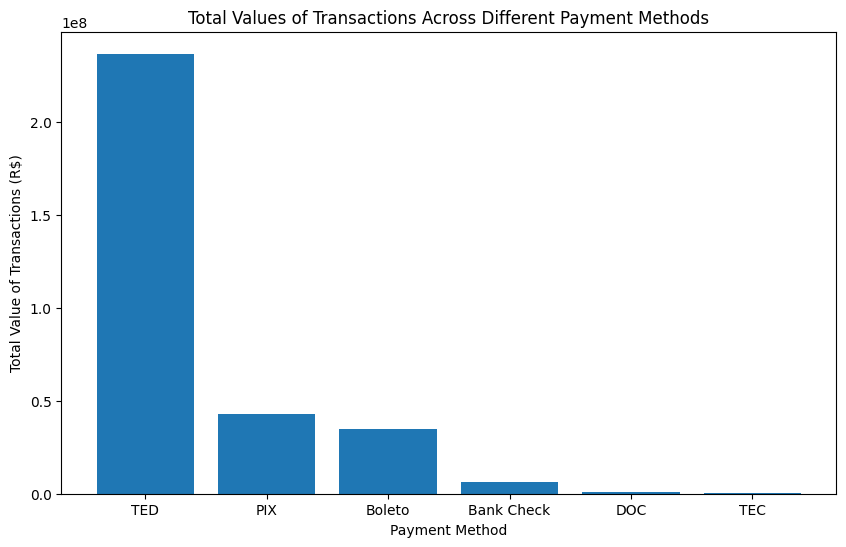

In [28]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(total_values_df['Payment Method'], total_values_df['Total Values (R$)'])
plt.xlabel('Payment Method')
plt.ylabel('Total Value of Transactions (R$)')
plt.title('Total Values of Transactions Across Different Payment Methods')
plt.show()

By combining the first and second chart, we can see that the method `PIX` is the popular one, however, it just started to be used near 2021, meaning its transaction record is very recent. where `TED` is an old method which it continues to be used to transfer money.

#### 4. Seasonal or monthly trends in using these payment methods

In [34]:
# Extract month and year from YearMonth
df['Month'] = df['YearMonth'].dt.month
df['Year'] = df['YearMonth'].dt.year

# Select only numeric columns before grouping
numeric_df = df.select_dtypes(include=['number'])

In [35]:
# Group by month and sum the transactions
monthly_trends = numeric_df.groupby('Month').sum().reset_index()

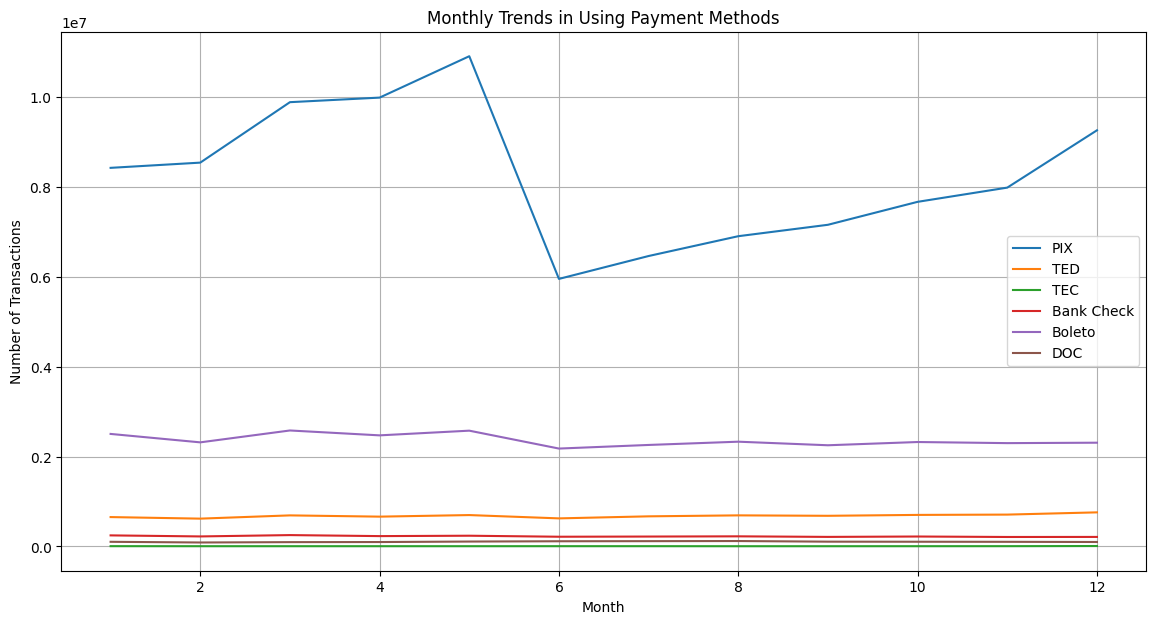

In [36]:
# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='quantityPix', data=monthly_trends, label='PIX')
sns.lineplot(x='Month', y='quantityTED', data=monthly_trends, label='TED')
sns.lineplot(x='Month', y='quantityTEC', data=monthly_trends, label='TEC')
sns.lineplot(x='Month', y='quantityBankCheck', data=monthly_trends, label='Bank Check')
sns.lineplot(x='Month', y='quantityBrazilianBoletoPayment', data=monthly_trends, label='Boleto')
sns.lineplot(x='Month', y='quantityDOC', data=monthly_trends, label='DOC')

plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Monthly Trends in Using Payment Methods')
plt.legend()
plt.grid(True)
plt.show()

The payment methods that suffer significant fluctuation during a year are:
- PIX: between April and June, for Bank or simular institute it might be a good insight or warning to try to understand the cause of the fluctuation.
- Boleto: the number of transaction litely descreaded in the same period as PIX, however, there isn't a pull back as PIX.
- Other Methods: in general the number of transactions is constant during the entire year.

#### 5. Insights from transaction volumes and values about consumer behavior